In [1]:
# automatically reflect changes in imported modules
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

import utils
import utils.logging_config
import logging
logger = logging.getLogger("task2 (mesh)")

In [2]:
DATA_ROOT = Path('data')
DATA_NAME = 'data0.txt'
# DATA_NAME = 'data1.txt'
# DATA_NAME = 'data0_noise.txt'
# DATA_NAME = 'data1_noise.txt'
NBINS = 30
CACHE_ROOT = Path('.cache')


In [3]:
points, columns = utils.load_data(DATA_ROOT / DATA_NAME)
logger.debug(f"Fetched {points.shape[0]} points, columns: {columns}")
# points = points[1:100, ...]
points = points[::5]
# TODO remove
# reorder the columns to match the expected order (x, y, z, mass)
particles = points[:, [2, 3, 4, 1]]

09:38:46 - utils.load - Loaded 1008 rows and 9 columns from data/data0.txt
09:38:46 - task2 (mesh) - Fetched 1008 points, columns: ['ID', 'M', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'eps']


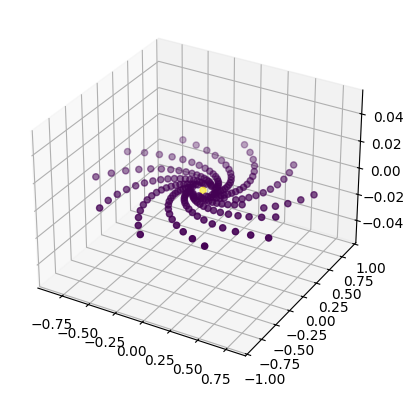

In [4]:
# plot the distribution of the particles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(particles[:,0], particles[:,1], particles[:,2], cmap='viridis', c=particles[:,3])
plt.show()
## Note: colormap corresponds to the mass of the particles

### Choice of units
Recap of the particle properties:
- $\sim 10^4$ particles
- around 1 black hole (10% of the mass)

$\implies$ ???

In [5]:
# Set G = 1
G = 1

# from the particle number we can estimate the total (stellar) mass, excluding the BH
M_TOT = 1e4 * u.M_sun
# the radius aound the black hole follows from ??? # TODO
R_TOT = 1 * u.pc

# Rescale the units of the particles - considering only the orbiting stars
M_particles = particles[:,3].sum() - 1
R_particles = np.max(np.linalg.norm(particles[:, :3], axis=1))

logger.info(f"Considering a globular cluster - total mass of stars: {M_particles}, maximum radius of particles: {R_particles}")
m_scale = M_TOT / M_particles
r_scale = R_TOT / R_particles
utils.seed_scales(r_scale, m_scale)


09:38:47 - task2 (mesh) - Considering a globular cluster - total mass of stars: 1.9960278053624618, maximum radius of particles: 0.9000000000000001
09:38:47 - utils.units - Set scales: M_SCALE = 5e+03 solMass, R_SCALE = 1.1 pc


In [6]:
### Direct N body force computation
epsilon = utils.mean_interparticle_distance(particles)

epsilon_range = np.logspace(-2, 2, 5)
n_squared_forces = []

SAVE_FORCES = False

for e in epsilon_range:
    n_particles = particles.shape[0]
    cache_file = CACHE_ROOT / f"n_squared_forces__n_{n_particles}__softening_multiplier_{e:.0f}.npy"
    try:
        f = np.load(cache_file)
        logger.info(f"Loaded forces from {cache_file}")
    except FileNotFoundError:
        f = utils.n_body_forces(particles, G, e * epsilon)
        if SAVE_FORCES:
            np.save(cache_file, f)
            logger.debug(f"Saved forces to {cache_file}")
    n_squared_forces.append(f)

### Mesh based force computation
mesh_size_range = [10, 20, 50, 100, 150, 200]
mapping = utils.particle_to_cells_nn

mesh_forces = []
for mesh_size in mesh_size_range:
    cache_file = CACHE_ROOT / f"mesh_forces__n_{n_particles}__mesh_size_{mesh_size}__mapping_{mapping.__name__}.npy"
    try:
        f = np.load(cache_file)
        logger.info(f"Loaded forces from {cache_file}")
    except FileNotFoundError:
        f = utils.mesh_forces_v2(particles, G, mesh_size, mapping)
        if SAVE_FORCES:
            np.save(cache_file, f)
            logger.debug(f"Saved forces to {cache_file}")
    mesh_forces.append(f)


09:38:47 - utils.particles - Half mass radius: 0.16294982222188462 for 50th particle of 202
09:38:47 - utils.particles - Number of particles within half mass radius: 43 of 202
09:38:47 - utils.particles - Found mean interparticle distance: 0.07497686469036202
09:38:47 - utils.forces_basic - Computing forces for 202 particles using n^2 algorithm (using softening=0.00075)
09:38:47 - utils.forces_basic - Particle 0 done
09:38:47 - utils.forces_basic - Computing forces for 202 particles using n^2 algorithm (using softening=0.0075)
09:38:47 - utils.forces_basic - Particle 0 done
09:38:47 - utils.forces_basic - Computing forces for 202 particles using n^2 algorithm (using softening=0.075)
09:38:47 - utils.forces_basic - Particle 0 done
09:38:47 - utils.forces_basic - Computing forces for 202 particles using n^2 algorithm (using softening=0.75)
09:38:47 - utils.forces_basic - Particle 0 done
09:38:47 - utils.forces_basic - Computing forces for 202 particles using n^2 algorithm (using softenin

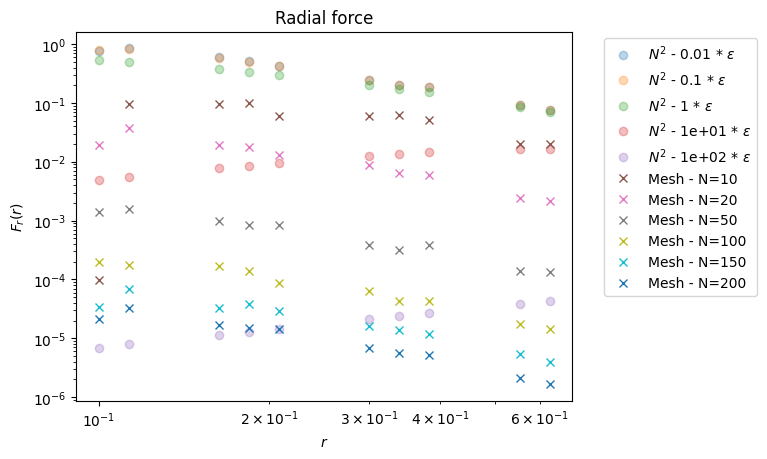

In [7]:
## Compare the mesh computation with the direct summation
r = np.linalg.norm(particles[:,:3], axis=1)

plt.figure()
plt.title('Radial force')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$')
plt.ylabel('$F_r(r)$')

# many of the particles have the same distance from the origin, so we skip some of them
SKIP_N = 20

for f, e in zip(n_squared_forces, epsilon_range):
    plt.plot(r[::SKIP_N], np.linalg.norm(f, axis=1)[::SKIP_N], 'o', label=f"$N^2$ - {e:.1g} * $\\epsilon$", alpha=0.3)
for f, s in zip(mesh_forces, mesh_size_range):
    plt.plot(r[::SKIP_N], np.linalg.norm(f, axis=1)[::SKIP_N], 'x', label=f"Mesh - N={s}")

# plt.ylim([5e-4, 1e2])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# TODO: compare computation time


#### Discussion
- Using the baseline of $N^2 + 1 \varepsilon$ softening we can see that already a 20 x 20 x 20 grid provides good accuracy but the mapping breaks down at small distances (dip)
- Larger grids are more stable, especially at small distances => 50 x 50 x 50 already seems to be a good choice
- very large grids show overdiscretization => noisy data even for the non-noisy particle distributions


### Time integration

In [8]:
import scipy.integrate as spi

In [9]:
# load the particles in the format [x, y, z, vx, vy, vz, mass]
p0 = points[:, [2, 3, 4, 5, 6, 7, 1]]

logger.info(f"Considering {p0.shape[0]} particles")
logger.info(f"Total mass: {np.sum(p0[:,6])}")

if logger.level <= logging.DEBUG:
    # assert that the ODE reshaping is consistent
    p0_ref = p0.copy()
    y0, _ = utils.ode_setup(p0, None)
    logger.debug(y0[0:7])
    p0_reconstructed = utils.to_particles(y0)
    logger.debug(f"{p0_ref[0]} -> {p0_reconstructed[0]}")
    logger.debug(f"{p0_ref[1]} -> {p0_reconstructed[1]}")

    assert np.allclose(p0_ref, p0_reconstructed)
    logger.debug("Consistency check passed")


09:38:49 - task2 (mesh) - Considering 202 particles
09:38:49 - task2 (mesh) - Total mass: 2.996027805362462
09:38:49 - utils.integrate - Reshaped 7 columns into particles.shape=(1414,)
09:38:49 - task2 (mesh) - [0.         0.16294982 0.3        0.55231726 0.09929811 0.18281353
 0.33657024]
09:38:49 - task2 (mesh) - [0. 0. 0. 0. 0. 0. 1.] -> [0. 0. 0. 0. 0. 0. 1.]
09:38:49 - task2 (mesh) - [ 0.16294982  0.          0.         -0.          2.94302832  0.
  0.00993049] -> [ 0.16294982  0.          0.         -0.          2.94302832  0.
  0.00993049]
09:38:49 - task2 (mesh) - Consistency check passed


In [10]:
def integrate(method: str, force_function: callable, p0: np.ndarray, t_range: np.ndarray) -> np.ndarray:
    """
    Integrate the gravitational movement of the particles, using the specified method
    - method: the integration method to use ("scipy" or "rk4")
    - force_function: the function that computes the forces acting on the particles
    - p0: the initial conditions of the particles (n, 7) array, unflattened
    - t_range: the time range to integrate over
    Returns: the integrated positions and velocities of the particles in a 'flattened' array (time_steps, nx7)
    """
    y0, y_prime = utils.ode_setup(p0, force_function)
    
    if method == "scipy":
        sol = spi.odeint(y_prime, y0, t_range, rtol=1e-2)
    elif method == "rk4":
        sol = np.zeros((t_range.shape[0], y0.shape[0]))
        sol[0] = y0
        dt = t_range[1] - t_range[0]
        for i in range(1, t_range.shape[0]):
            t = t_range[i]
            sol[i,...] = utils.runge_kutta_4(sol[i-1], t, y_prime, dt)


    logger.info(f"Integration done, shape: {sol.shape}")
    return sol


In [11]:
# Determine the integration timesteps
# let's first compute the crossing time
v = np.linalg.norm(particles[:, 3:6], axis=1)
v_mean = np.mean(v)
# a timestep should result in a small displacement, wrt. to the mean interparticle distance
r_inter = utils.mean_interparticle_distance(particles)

dt = r_inter / v_mean * 1e-3
logger.info(f"Mean velocity: {v_mean}, timestep: {dt}")

if np.isnan(dt):
    raise ValueError("Invalid timestep")

09:38:49 - utils.particles - Half mass radius: 0.16294982222188462 for 50th particle of 202
09:38:49 - utils.particles - Number of particles within half mass radius: 43 of 202
09:38:49 - utils.particles - Found mean interparticle distance: 0.07497686469036202
09:38:49 - task2 (mesh) - Mean velocity: 0.014831820818626048, timestep: 0.005055135549925524


In [12]:
## Integration setup - use the n_squared forces for a few timesteps only, to see if the orbits are stable
t_orbit = 2 * np.pi * r_inter / v_mean
n_steps = int(t_orbit / dt * 5)
n_steps = 10
t_range = np.arange(0, n_steps*dt, dt)
logger.info(f"Integration range: {t_range[0]} -> {t_range[-1]}, n_steps: {n_steps}")

# The force function can be interchanged
epsilon = utils.mean_interparticle_distance(particles)
# epsilon = 0.01

force_function = lambda x: utils.n_body_forces(x, G, epsilon)
# force_function = lambda x: 0
# force_function = lambda x: utils.n_body_forces_basic(x, G, epsilon)
# force_function = lambda x: utils.analytical_forces(x)
# force_function = lambda x: utils.mesh_forces_v2(x, G, 50, utils.particle_to_cells_nn)


sol = integrate("rk4", force_function, p0, t_range)

09:38:49 - task2 (mesh) - Integration range: 0.0 -> 0.045496219949329716, n_steps: 10
09:38:49 - utils.particles - Half mass radius: 0.16294982222188462 for 50th particle of 202
09:38:49 - utils.particles - Number of particles within half mass radius: 43 of 202
09:38:49 - utils.particles - Found mean interparticle distance: 0.07497686469036202
09:38:49 - utils.integrate - Reshaped 7 columns into particles.shape=(1414,)
09:38:49 - utils.forces_basic - Computing forces for 202 particles using n^2 algorithm (using softening=0.075)
09:38:49 - utils.forces_basic - Particle 0 done
09:38:49 - utils.forces_basic - Computing forces for 202 particles using n^2 algorithm (using softening=0.075)
09:38:49 - utils.forces_basic - Particle 0 done
09:38:49 - utils.forces_basic - Computing forces for 202 particles using n^2 algorithm (using softening=0.075)
09:38:49 - utils.forces_basic - Particle 0 done
09:38:49 - utils.forces_basic - Computing forces for 202 particles using n^2 algorithm (using soften

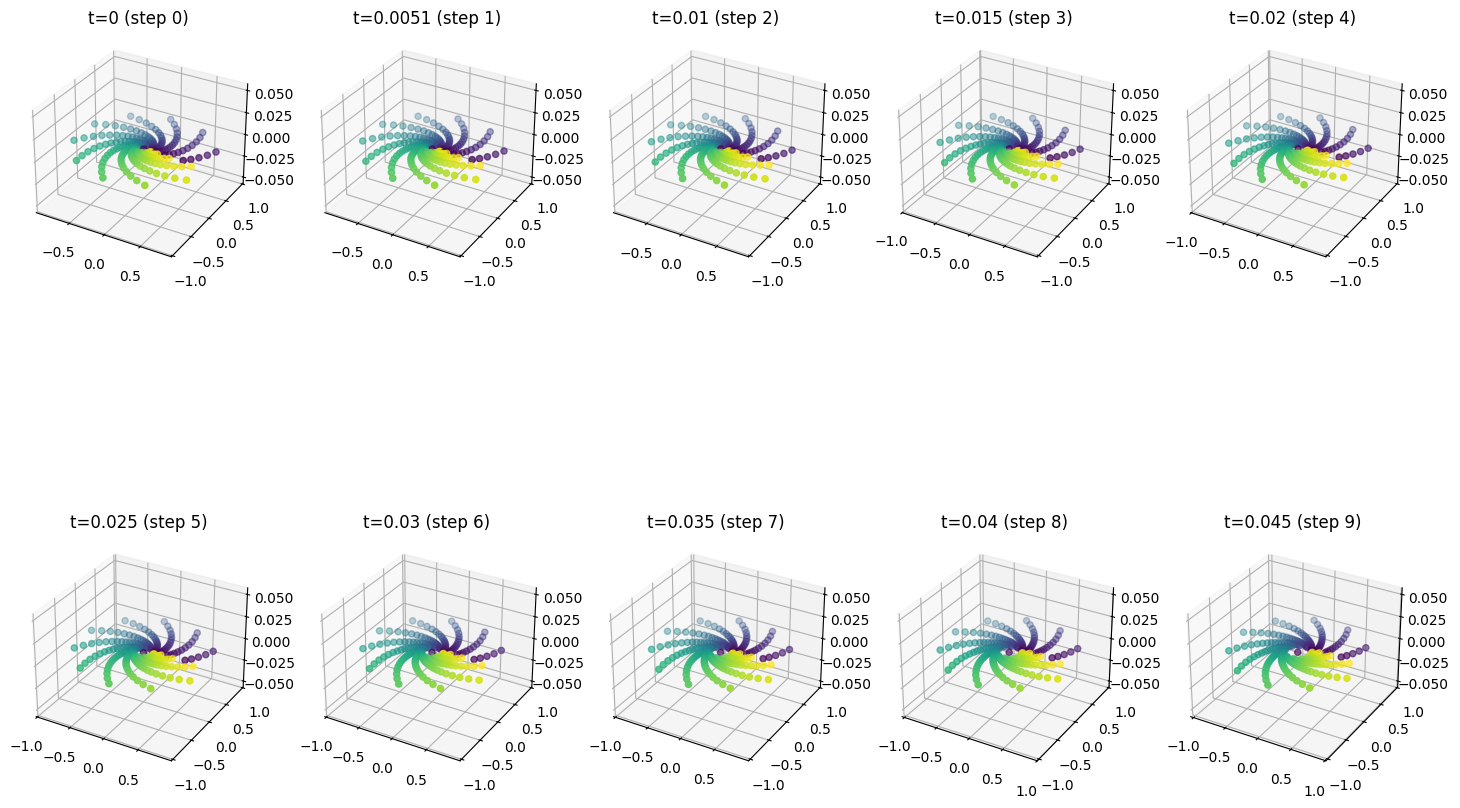

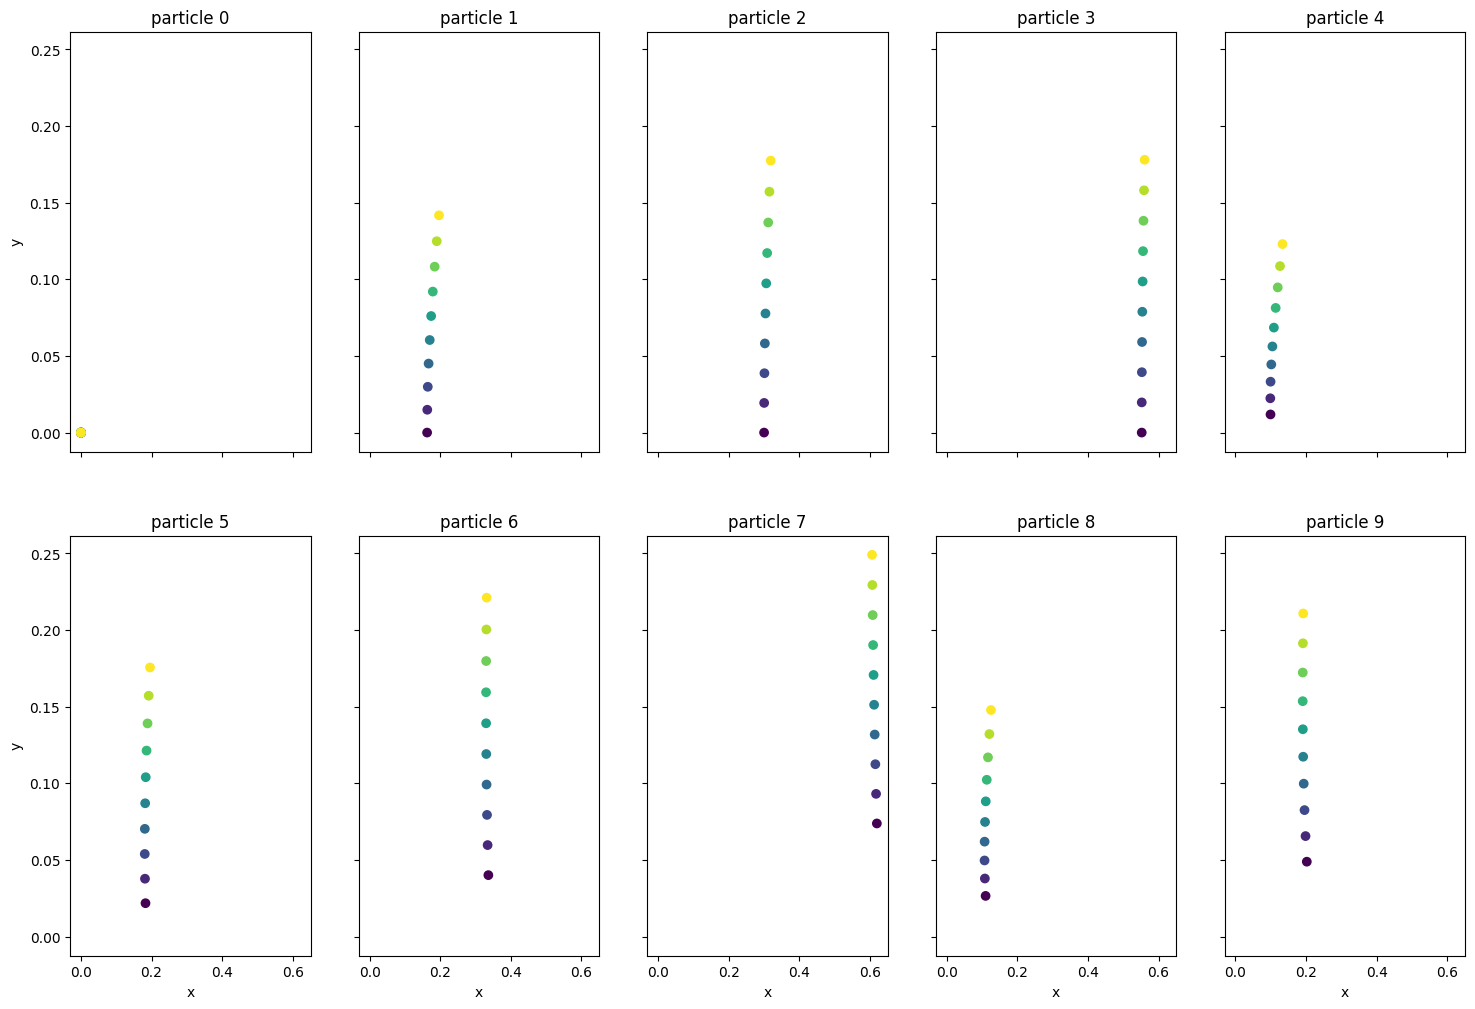

In [13]:
### Plot a fixed number of states
SHOW_N_STATES = 10 # should be even
# skip some particles to make the plot more readable
SHOW_NTH_PARTICLE = 1

particles_in_time = utils.to_particles_3d(sol)

## Show the particles in 3D
fig, axs = plt.subplots(2, SHOW_N_STATES//2, subplot_kw={'projection': '3d'})

for i, ax in enumerate(axs.flat):
    nth = int(particles_in_time.shape[0] / SHOW_N_STATES) * i
    p = particles_in_time[nth][::SHOW_NTH_PARTICLE]
    ax.scatter(p[:,0], p[:,1], p[:,2], cmap='viridis', c=range(p.shape[0]))
    ax.set_title(f"t={t_range[nth]:.2g} (step {nth})")

fig.set_size_inches(18, 12)
plt.show()

# show some phase space diagrams
# fig, axs = plt.subplots(2, SHOW_N_STATES//2, sharex=True, sharey=True)
# for i, ax in enumerate(axs.flat):
#     r = []
#     v = []
#     for j in range(t_range.size):
#         p = utils.to_particles(sol[j])
#         print(p.shape)
#         r.append(np.linalg.norm(p[i,:3]))
#         v.append(np.linalg.norm(p[i,3:6]))
#     ax.plot(r, v)
#     ax.set_title(f"particle {i}")

## Show the 2D orbits of selected particles
fig, axs = plt.subplots(2, SHOW_N_STATES//2, sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    nth = int(particles_in_time.shape[0] / SHOW_N_STATES) * i
    x = particles_in_time[:,i,0]
    y = particles_in_time[:,i,1]
    ax.scatter(x, y, c=range(t_range.size))
    ax.set_title(f"particle {nth}")

    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Share x and y axis
for ax in axs.flat:
    ax.label_outer()

fig.set_size_inches(18, 12)
plt.show()


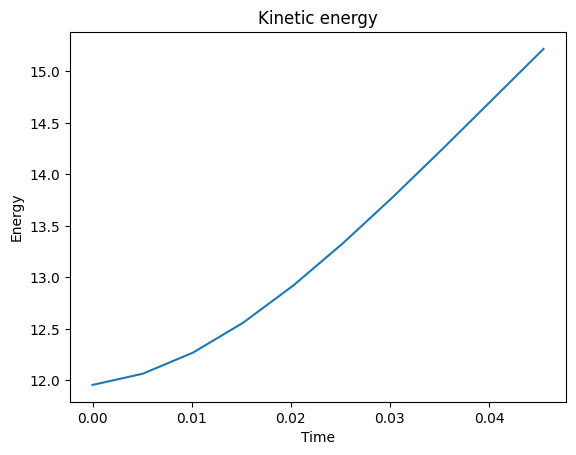

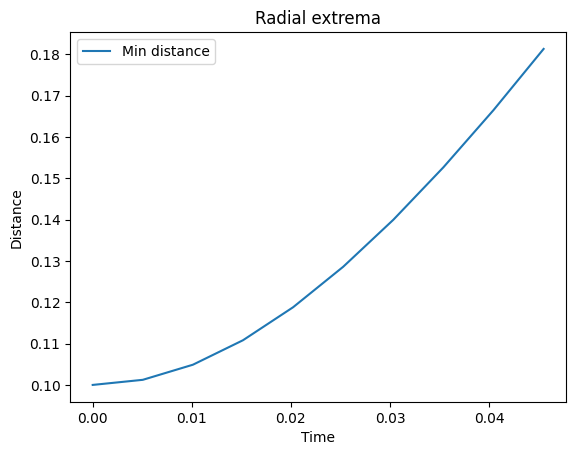

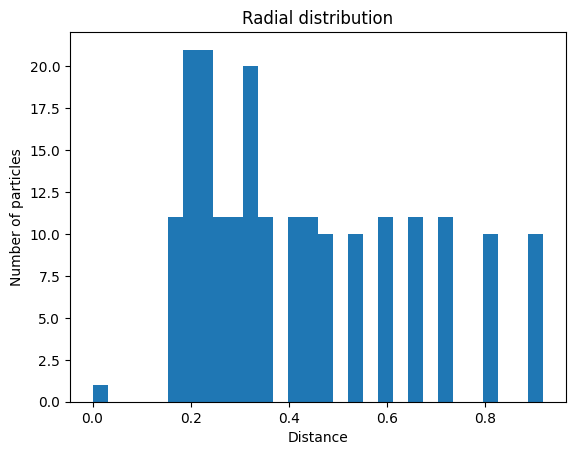

In [14]:
#### Plot some key quantities of the system as a whole
# sol has the shape (n_steps, n_particles*6) where the first 3*n are the positions and the last 3*n are the velocities

# kinetic energy
energies = np.zeros(sol.shape[0])
for i in range(sol.shape[0]):
    p = utils.to_particles(sol[i])
    k_e = 0.5 * np.sum(p[:,6] * np.linalg.norm(p[:,3:6], axis=1)**2)
    energies[i] = k_e

plt.figure()
plt.plot(t_range, energies)
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()


# radial extrema of the particles
r_mins = np.zeros(sol.shape[0])
r_maxs = np.zeros(sol.shape[0])
for i in range(sol.shape[0]):
    p = utils.to_particles(sol[i])
    r = np.linalg.norm(p[:,:3], axis=1)
    r_mins[i] = np.partition(r, 4)[4]

    # r_mins[i] = np.min(r)
    r_maxs[i] = np.max(r)

plt.figure()
plt.plot(t_range, r_mins, label='Min distance')
# plt.plot(t_range, r_maxs, label='Max distance')
plt.title('Radial extrema')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()

# plot the last radial distribution
plt.figure()
plt.hist(r, bins=NBINS)
plt.title('Radial distribution')
plt.xlabel('Distance')
plt.ylabel('Number of particles')
plt.show()


### Full PM solver
We now have all the tools to implement the full PM solver:
- force computation using mesh
- integrator with RK4
- estimate for good timesteps

In [15]:
## Integration setup - use the n_squared forces for a few timesteps only, to see if the orbits are stable
t_orbit = 2 * np.pi * r_inter / v_mean
n_steps = int(t_orbit / dt * 30)
t_range = np.arange(0, n_steps*dt, dt)
logger.info(f"Integration range: {t_range[0]} -> {t_range[-1]}, n_steps: {n_steps}")


mesh_size = 50 # as per the previous discussion
force_function = lambda x: utils.mesh_forces_v2(x, G, mesh_size, utils.particle_to_cells_nn)

sol = integrate("rk4", force_function, p0, t_range)

09:38:52 - task2 (mesh) - Integration range: 0.0 -> 952.8627203476617, n_steps: 188495
09:38:52 - utils.integrate - Reshaped 7 columns into particles.shape=(1414,)
09:38:52 - utils.forces_mesh - Computing forces for 202 particles using mesh [mapping=particle_to_cells_nn, n_grid=50]
09:38:52 - utils.forces_mesh - Using mesh spacing: 0.036589586055252865
09:38:52 - utils.forces_mesh - Got k_square with: (50, 50, 50), 560.2040843578968 0.0
09:38:52 - utils.forces_mesh - Count of zeros: 1
09:38:52 - utils.forces_mesh - Got phi with: (50, 50, 50), 0.0023263587300085347
09:38:52 - utils.forces_mesh - Computing forces for 202 particles using mesh [mapping=particle_to_cells_nn, n_grid=50]
09:38:52 - utils.forces_mesh - Using mesh spacing: 0.03655587384174008
09:38:52 - utils.forces_mesh - Got k_square with: (50, 50, 50), 561.2378130598636 0.0
09:38:52 - utils.forces_mesh - Count of zeros: 1
09:38:52 - utils.forces_mesh - Got phi with: (50, 50, 50), 0.0023276852959839096
09:38:52 - utils.forces

KeyboardInterrupt: 

In [ ]:
## Show some results